## M5 - Sales Forecasting
### Objective - Overall objective it to forecast the sales of products in future horizon for bettter managment of invetory

#### Approach follwed - 
#### 1. Performed the basic sanity checks of provided dataset just to ensure we have appropriate details (no missing values, no duplicates etc.)
#### 2. Preparing for time series - Merging the required columns from calendar dataset and set the date as index instead of day numbers
#### 3. Use of DeepAR model to forecast sales at product level for future horizon
#### 4. Use of DeepAR model to forecast sales aggregated at store level
#### 5. Use of LSTM model to forecast sales aggregated at store level

#### NOTE - All the models demnostrate the learnings and methodology used to achieve the objective. Focus was more on implemetning the models rather than improving those for further accuracy

#### Import required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Get the required data from kaggle

In [2]:
calendar = pd.read_csv('calendar.csv')
train_data = pd.read_csv('sales_train_evaluation.csv')
sell_prices = pd.read_csv('sell_prices.csv')

In [3]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
train_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [5]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


#### Basic sanity check of data

In [7]:
# Define the function to check duplicate entries, null values and display the columns having null values from a given dataset
def basic_check(df):
    duplicate_counts = df.duplicated().sum()
    null_counts = df.isnull().sum()
    columns_with_null = null_counts[null_counts > 0]
    print("duplicate counts:", duplicate_counts)
    print("Columns having null values in the dataset:\n", columns_with_null, sep = '')  
    print(df.shape)

In [8]:
# Basic checks on calendar dataset
basic_check(calendar)

# Observed 4 columns typically related to event occurence are having null values. This is obvious as not every day can be event day.

duplicate counts: 0
Columns having null values in the dataset:
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
dtype: int64
(1969, 14)


In [9]:
# Basic checks on train_data dataset
basic_check(train_data)

# No duplicates and null values observed 

duplicate counts: 0
Columns having null values in the dataset:
Series([], dtype: int64)
(30490, 1947)


In [10]:
# Basic checks on sells dataset
basic_check(sell_prices)

# No duplicates and null values observed 

duplicate counts: 0
Columns having null values in the dataset:
Series([], dtype: int64)
(6841121, 4)


In [11]:
# Replacing the null values in calendar datasert to zero. This will simpify the operational procesess on dataset.
calendar.fillna(0, inplace=True)

In [12]:
basic_check(calendar)

# Confirming null values replaced with zeros

duplicate counts: 0
Columns having null values in the dataset:
Series([], dtype: int64)
(1969, 14)


In [13]:
# Define the function to reduce the memory utilization by dataset.
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [14]:
# Reducing the memory of Train_data as it contains sells of 30,490 products on 1947 days
downcast_dtypes(train_data)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [15]:
train_data.info()

# Observe the memory utilization by the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int16(1941), object(6)
memory usage: 114.3+ MB


In [16]:
# datset by dropping the 'id' columns. These are just for indentification purpose and will not be useful for time series forecasting except key (product id)
train_data_req = train_data.drop(columns=['item_id','dept_id','cat_id','store_id','state_id'])

In [17]:
train_data_req.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [18]:
# Transposing the dataset as we are preapering to have dates as index, necessity for time series forecasting
train_data_req = train_data_req.T

In [19]:
train_data_req.head()

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0


In [20]:
# Extracting first row of dataset so that it can assigned as column headings
new_col = train_data_req.iloc[0].tolist()

In [21]:
# Assigning list as column headings
train_data_req.columns = new_col

In [22]:
train_data_req.head()

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0


In [23]:
train_data_req = train_data_req.drop('id')

In [24]:
train_data_req.head()

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


In [25]:
train_data_req.index

# Ensuring indexes are day numbers

Index(['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1941)

In [26]:
# Evaluating the sum of every product sales over given period
col_sum = train_data_req.sum()

In [27]:
# Checking if there are any products with zero sales, so that those products can be straight away elliminated from the forecasting analysis
cols_with_zero_sum = col_sum[col_sum == 0]

In [28]:
cols_with_zero_sum

# No products with zero sales

Series([], dtype: object)

#### Merging the required columns from calendar dataset and set the date as index instead of day numbers

In [29]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,0,0,0,0,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,0,0,0,0,1,0,1


In [30]:
print(calendar['event_name_1'].unique())
print(len(calendar['event_name_1'].unique()))

# There are 31 unique events under event_name_1

[0 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']
31


In [31]:
print(calendar['event_name_2'].unique())
print(len(calendar['event_name_2'].unique()))

# There are 5 unique events under event_name_2 and those are part of event_name_1 too

[0 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]
5


In [32]:
calendar[calendar['event_name_1'] != 0]

# There are 162 days with event_name_1

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,0,0,1,1,1
16,2011-02-14,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,0,0,0,0,1
23,2011-02-21,11104,Monday,3,2,2011,d_24,PresidentsDay,National,0,0,0,0,0
39,2011-03-09,11106,Wednesday,5,3,2011,d_40,LentStart,Religious,0,0,1,1,1
46,2011-03-16,11107,Wednesday,5,3,2011,d_47,LentWeek2,Religious,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,2016-05-08,11615,Sunday,2,5,2016,d_1927,Mother's day,Cultural,0,0,1,0,1
1948,2016-05-30,11618,Monday,3,5,2016,d_1949,MemorialDay,National,0,0,0,0,0
1951,2016-06-02,11618,Thursday,6,6,2016,d_1952,NBAFinalsStart,Sporting,0,0,1,0,1
1956,2016-06-07,11619,Tuesday,4,6,2016,d_1957,Ramadan starts,Religious,0,0,1,1,0


In [33]:
calendar[calendar['event_name_2'] != 0]

# There are 5 days with event_name_2

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
85,2011-04-24,11113,Sunday,2,4,2011,d_86,OrthodoxEaster,Religious,Easter,Cultural,0,0,0
827,2013-05-05,11315,Sunday,2,5,2013,d_828,OrthodoxEaster,Religious,Cinco De Mayo,Cultural,1,1,1
1177,2014-04-20,11412,Sunday,2,4,2014,d_1178,Easter,Cultural,OrthodoxEaster,Religious,0,0,0
1233,2014-06-15,11420,Sunday,2,6,2014,d_1234,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [34]:
# Define the list of columns to be dropped from calendar dataset before merging with train_data

col_to_drop = ['wm_yr_wk', 'weekday', 'wday', 'month', 'year','event_type_1','event_type_2']

In [35]:
# Drop the columns from calendar dataset
calendar = calendar.drop(columns= col_to_drop)

In [36]:
calendar.head()

,date,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,d_1,0,0,0,0,0
1,2011-01-30,d_2,0,0,0,0,0
2,2011-01-31,d_3,0,0,0,0,0
3,2011-02-01,d_4,0,0,1,1,0
4,2011-02-02,d_5,0,0,1,0,1


In [37]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   d             1969 non-null   object
 2   event_name_1  1969 non-null   object
 3   event_name_2  1969 non-null   object
 4   snap_CA       1969 non-null   int64 
 5   snap_TX       1969 non-null   int64 
 6   snap_WI       1969 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 107.8+ KB


In [38]:
# Convert event_name columns to numerical
# If any event is present on any day, we will assign 1. Meaning, presence of event will be assigned with 1 and absence with zero.
calendar['event_name_1'] = calendar['event_name_1'].apply(lambda x: 1 if x != 0 else x)
calendar['event_name_2'] = calendar['event_name_2'].apply(lambda x: 1 if x != 0 else x)

In [39]:
calendar.head()

,date,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,d_1,0,0,0,0,0
1,2011-01-30,d_2,0,0,0,0,0
2,2011-01-31,d_3,0,0,0,0,0
3,2011-02-01,d_4,0,0,1,1,0
4,2011-02-02,d_5,0,0,1,0,1


In [40]:
calendar.info()

#calendar dataset is ready for merging

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   d             1969 non-null   object
 2   event_name_1  1969 non-null   int64 
 3   event_name_2  1969 non-null   int64 
 4   snap_CA       1969 non-null   int64 
 5   snap_TX       1969 non-null   int64 
 6   snap_WI       1969 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 107.8+ KB


In [41]:
downcast_dtypes(calendar)

,date,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,d_1,0,0,0,0,0
1,2011-01-30,d_2,0,0,0,0,0
2,2011-01-31,d_3,0,0,0,0,0
3,2011-02-01,d_4,0,0,1,1,0
4,2011-02-02,d_5,0,0,1,0,1
...,...,...,...,...,...,...,...
1964,2016-06-15,d_1965,0,0,0,1,1
1965,2016-06-16,d_1966,0,0,0,0,0
1966,2016-06-17,d_1967,0,0,0,0,0
1967,2016-06-18,d_1968,0,0,0,0,0


In [42]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   d             1969 non-null   object
 2   event_name_1  1969 non-null   int16 
 3   event_name_2  1969 non-null   int16 
 4   snap_CA       1969 non-null   int16 
 5   snap_TX       1969 non-null   int16 
 6   snap_WI       1969 non-null   int16 
dtypes: int16(5), object(2)
memory usage: 50.1+ KB


In [43]:
# Resetting the index so that we can perform merge operation with calendar dataset
train_data_req.reset_index(inplace=True)

In [44]:
train_data_req.head()

,index,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
0,d_1,0,0,0,0,0,0,0,12,2,...,0,14,1,0,4,0,0,0,0,0
1,d_2,0,0,0,0,0,0,0,15,0,...,0,11,1,0,4,0,0,6,0,0
2,d_3,0,0,0,0,0,0,0,0,7,...,0,5,1,0,2,2,0,0,0,0
3,d_4,0,0,0,0,0,0,0,0,3,...,0,6,1,0,5,2,0,2,0,0
4,d_5,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


In [45]:
# Rename the index column as 'd', same as that in caendar dataset
train_data_req = train_data_req.rename(columns={'index': 'd'})

In [46]:
calendar_cat = pd.read_csv('calendar.csv')

In [47]:
# Drop the columns from calendar dataset
calendar_cat = calendar_cat.drop(columns= col_to_drop)

In [48]:
calendar_cat.fillna(0, inplace=True)

In [49]:
calendar_cat.head()

,date,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,d_1,0,0,0,0,0
1,2011-01-30,d_2,0,0,0,0,0
2,2011-01-31,d_3,0,0,0,0,0
3,2011-02-01,d_4,0,0,1,1,0
4,2011-02-02,d_5,0,0,1,0,1


In [50]:
# Merge the calendar dataset in train dataset based on day number
train_data_with_cat = train_data_req.merge(calendar_cat, on = ['d'], how = 'left')

In [51]:
train_data_with_cat.head()

,d,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,...,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation,date,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,d_1,0,0,0,0,0,0,0,12,2,...,0,0,0,0,2011-01-29,0,0,0,0,0
1,d_2,0,0,0,0,0,0,0,15,0,...,0,6,0,0,2011-01-30,0,0,0,0,0
2,d_3,0,0,0,0,0,0,0,0,7,...,0,0,0,0,2011-01-31,0,0,0,0,0
3,d_4,0,0,0,0,0,0,0,0,3,...,0,2,0,0,2011-02-01,0,0,1,1,0
4,d_5,0,0,0,0,0,0,0,0,0,...,0,2,0,0,2011-02-02,0,0,1,0,1


In [52]:
train_data_with_cat = train_data_with_cat.drop(columns='d')

In [53]:
train_data_with_cat.set_index('date', inplace=True)

In [54]:
train_data_with_cat.index = pd.to_datetime(train_data_with_cat.index)

In [55]:
train_data_with_cat.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq=None)

In [56]:
train_data_with_cat.head()

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,0,6,0,0,0,0,0,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,2,0,0,0,0,0,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,2,0,2,0,0,0,0,1,1,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,1,0,1


In [57]:
train_data_with_cat.tail()

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,0,0,0,1,0,0,1,5,0,1,...,1,0,1,0,0,0,0,0,0,0
2016-05-19,3,0,2,3,0,0,0,4,0,1,...,0,1,0,1,2,0,0,0,0,0
2016-05-20,3,0,3,0,2,5,1,1,0,0,...,0,0,1,1,2,0,0,0,0,0
2016-05-21,0,0,0,2,1,2,1,40,1,0,...,1,1,0,1,5,0,0,0,0,0
2016-05-22,1,0,1,6,0,0,0,32,0,1,...,1,0,2,0,1,0,0,0,0,0


In [131]:
train_data_with_cat.shape

(1941, 30495)

#### TRY DEEPAR MODEL

In [132]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

In [133]:
def ready_data(dataset):
    # Prepare dataset without non-catergorical features
    data_without_cat = dataset.drop(columns=['event_name_1','event_name_2','snap_CA','snap_TX','snap_WI'])
    # Coverting categorical time series to arrray
    ts_code = dataset['event_name_1'].astype('category').cat.codes.values
    # training and testing sets split
    df_train = data_without_cat.iloc[:-28].T.values.astype(np.int16)
    df_test = data_without_cat.T.values.astype(np.int16)

    # Check the dataset size
    print("Shape of Train Dataset",df_train.shape)
    print("Shape of Test Dataset",df_test.shape)
    print("Shape of event_name_1 Dataset", ts_code.reshape(1,-1).shape)

    return df_train, df_test, ts_code

In [134]:
def train_test_dataset(df_train, df_test, ts_code, start_train, freq):
    train_ds = ListDataset([
        {
            FieldName.TARGET: target,
            FieldName.START: start_train,
            FieldName.FEAT_STATIC_CAT: fsc
        }
        for (target, fsc) in zip(df_train,
                                 ts_code.reshape(-1, 1))
    ], freq=freq)
     
    test_ds = ListDataset([
        {
            FieldName.TARGET: target,
            FieldName.START: start_train,
            FieldName.FEAT_STATIC_CAT: fsc
        }
        for (target, fsc) in zip(df_test,
                                 ts_code.reshape(-1, 1))
    ], freq=freq)
    return train_ds, test_ds

In [135]:
# Call function to make the datasets ready
df_train, df_test, ts_code = ready_data(train_data_with_cat)           

# Defining the required parameters
freq = "1D"
start_train = pd.to_datetime("2011-01-29 00:00:00")
start_test = pd.to_datetime("2011-02-26 00:00:00")
prediction_length = 28

# Call the function to prepare GluOnTs train and test datasets
train_ds, test_ds = train_test_dataset(df_train, df_test, ts_code, start_train, freq)

Shape of Train Dataset (30490, 1913)
Shape of Test Dataset (30490, 1941)
Shape of event_name_1 Dataset (1, 1941)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | In sizes                                                         | Out sizes   
------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 70.7 K | [[1, 1], [1, 1], [1, 1204, 4], [1, 1204], [1, 1204], [1, 28, 4]] | [1, 100, 28]
------------------------------------------------------------------------------------------------------------------------
70.7 K    Trainable params
0         Non-trainable params
70.7 K    Total params
0.283     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached -3.92404 (best -3.92404), saving model to 'C:\\Users\\admin\\Desktop\\Lilly Assignment\\CODE\\M5\\lightning_logs\\version_30\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -4.40024 (best -4.40024), saving model to 'C:\\Users\\admin\\Desktop\\Lilly Assignment\\CODE\\M5\\lightning_logs\\version_30\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached -5.11701 (best -5.11701), saving model to 'C:\\Users\\admin\\Desktop\\Lilly Assignment\\CODE\\M5\\lightning_logs\\version_30\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached -5.30740 (best -5.30740), saving model to 'C:\\Users\\admin\\Desktop\\Lilly Assignment\\CODE\\M5\\lightning_logs\\version_30\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


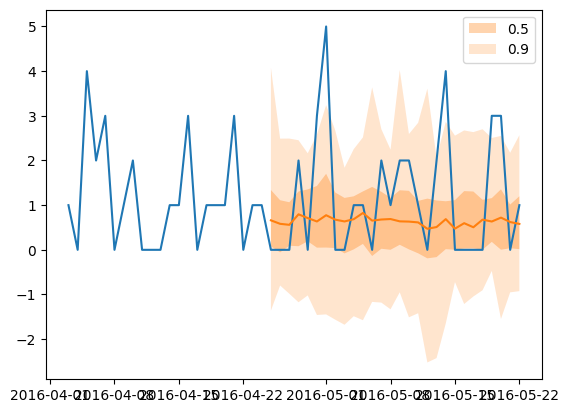

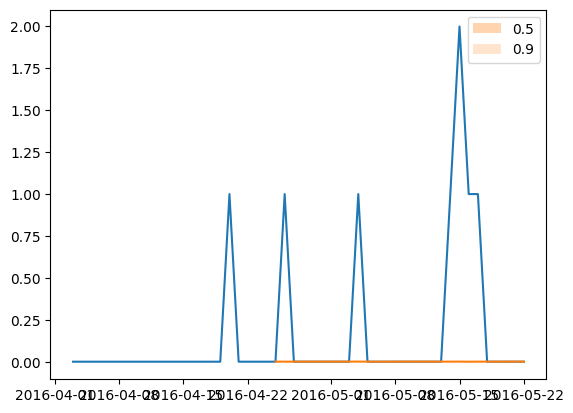

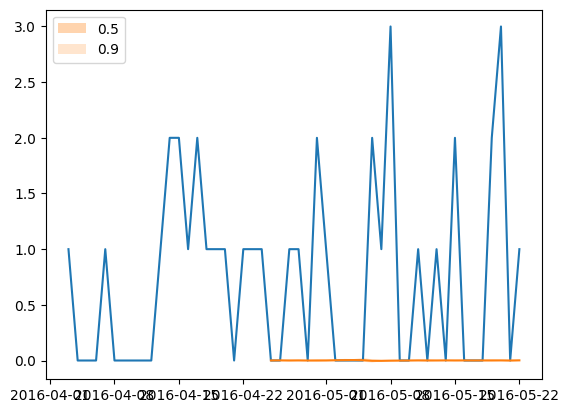

In [136]:
# Define DeepArEstimator
estimator = DeepAREstimator(freq=freq,                              # Frequency of the data to train on and predict
                        context_length=prediction_length*4,                  # Number of steps to unroll the RNN for before computing predictions
                        prediction_length=prediction_length,    # Length of the prediction horizon
                        num_feat_static_cat = 1,
                        cardinality=[31],                       # Number of values of each categorical feature
                        num_layers=8,                           # Number of RNN layers
                        hidden_size = 32,
                        dropout_rate=0.25,                      # Dropout regularization parameter
                        trainer_kwargs={'max_epochs': 5}        # Additional arguments to provide
                        )

# Train the model on training dataset
predictor = estimator.train(training_data=train_ds)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100,
)

tss = list(ts_it)
forecasts = list(forecast_it)

for i in range(3):
    # first entry of the time series list
    ts_entry = tss[i]
    # first entry of the forecast list
    forecast_entry = forecasts[i]
    plt.figure()
    plt.plot(ts_entry[-50:].to_timestamp())
    forecast_entry.plot(show_label=True)
    plt.legend()
plt.show()

In [137]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)
print()
print("Overall RMSE:", agg_metrics["RMSE"])
print()

Running evaluation: 1941it [00:06, 282.49it/s]



Overall RMSE: 1.8913522356210235



## Store Level Sales Prediction using DeepAR Model

In [144]:
store_data = train_data.drop(columns=['id','item_id','dept_id','cat_id','state_id'])

In [145]:
store_data = store_data.groupby(store_data['store_id']).sum()
store_data

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,...,4295,4155,5383,4341,4052,3710,3288,4390,4712,4974
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,3978,5527,5488,3505,3323,3242,3478,3813,5002,5054
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,5317,7704,7586,5011,4628,4533,4628,4880,5213,5068


In [146]:
store_data['d'] = store_data.index
store_data_T = store_data.transpose() 
store_data_T['d'] = store_data_T.index
store_data_T

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,d
d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,d_1
d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,d_2
d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,d_3
d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,d_4
d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,d_5
...,...,...,...,...,...,...,...,...,...,...,...
d_1938,4136,4037,5580,2544,2748,3126,3288,3478,4628,3398,d_1938
d_1939,4433,4751,5542,2704,3664,4249,4390,3813,4880,4126,d_1939
d_1940,5764,7120,7073,3146,4167,4802,4712,5002,5213,4519,d_1940
d_1941,6289,6614,8144,3597,4624,5217,4974,5054,5068,4757,d_1941


In [161]:
store_sales = store_data_T.merge(calendar, on='d')
store_sales.head()

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,d,date,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,d_1,2011-01-29,0,0,0,0,0
1,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,d_2,2011-01-30,0,0,0,0,0
2,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,d_3,2011-01-31,0,0,0,0,0
3,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,d_4,2011-02-01,0,0,1,1,0
4,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,d_5,2011-02-02,0,0,1,0,1


In [162]:
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales.set_index('date', inplace=True)
store_sales.head()

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,d_1,0,0,0,0,0
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,d_2,0,0,0,0,0
2011-01-31,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,d_3,0,0,0,0,0
2011-02-01,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,d_4,0,0,1,1,0
2011-02-02,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,d_5,0,0,1,0,1


In [164]:
store = store_sales.drop(columns='d')

In [165]:
store.shape

(1941, 15)

In [166]:
# Call function to make the datasets ready
df_train, df_test, ts_code = ready_data(store)           

# Defining the required parameters
freq = "1D"
start_train = pd.to_datetime("2011-01-29 00:00:00")
start_test = pd.to_datetime("2011-02-26 00:00:00")
prediction_length = 28

# Call the function to prepare GluOnTs train and test datasets
train_ds, test_ds = train_test_dataset(df_train, df_test, ts_code, start_train, freq)

Shape of Train Dataset (10, 1913)
Shape of Test Dataset (10, 1941)
Shape of event_name_1 Dataset (1, 1941)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | In sizes                                                         | Out sizes   
------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 70.7 K | [[1, 1], [1, 1], [1, 1204, 4], [1, 1204], [1, 1204], [1, 28, 4]] | [1, 100, 28]
------------------------------------------------------------------------------------------------------------------------
70.7 K    Trainable params
0         Non-trainable params
70.7 K    Total params
0.283     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.50779 (best 8.50779), saving model to 'C:\\Users\\admin\\Desktop\\Lilly Assignment\\CODE\\M5\\lightning_logs\\version_32\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.74584 (best 7.74584), saving model to 'C:\\Users\\admin\\Desktop\\Lilly Assignment\\CODE\\M5\\lightning_logs\\version_32\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.73525 (best 7.73525), saving model to 'C:\\Users\\admin\\Desktop\\Lilly Assignment\\CODE\\M5\\lightning_logs\\version_32\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.72556 (best 7.72556), saving model to 'C:\\Users\\admin\\Desktop\\Lilly Assignment\\CODE\\M5\\lightning_logs\\version_32\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 7.70722 (best 7.70722), saving mode

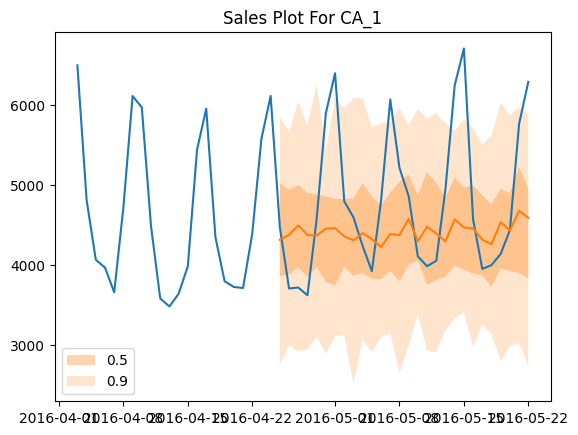

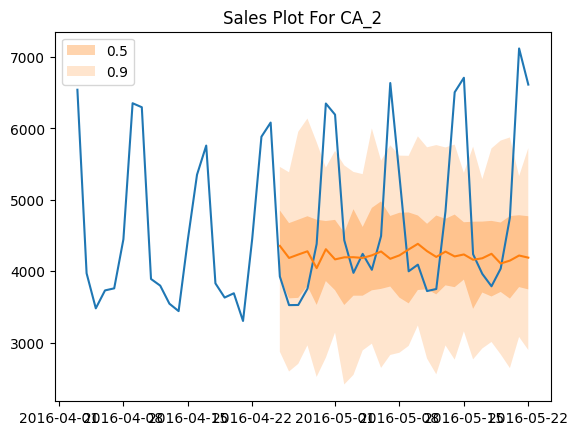

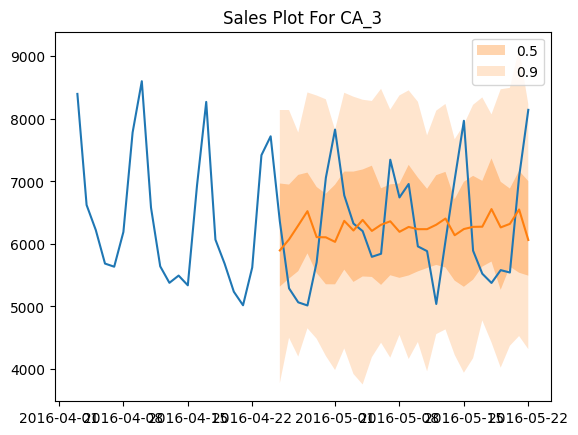

In [170]:
# Define DeepArEstimator
estimator = DeepAREstimator(freq=freq,                              # Frequency of the data to train on and predict
                        context_length=prediction_length*4,                  # Number of steps to unroll the RNN for before computing predictions
                        prediction_length=prediction_length,    # Length of the prediction horizon
                        num_feat_static_cat = 1,
                        cardinality=[31],                       # Number of values of each categorical feature
                        num_layers=8,                           # Number of RNN layers
                        hidden_size = 32,
                        dropout_rate=0.25,                      # Dropout regularization parameter
                        trainer_kwargs={'max_epochs': 10}        # Additional arguments to provide
                        )

# Train the model on training dataset
predictor = estimator.train(training_data=train_ds)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100,
)

tss = list(ts_it)
forecasts = list(forecast_it)

for i in range(3):
    # first entry of the time series list
    ts_entry = tss[i]
    # first entry of the forecast list
    forecast_entry = forecasts[i]
    plt.figure()
    plt.plot(ts_entry[-50:].to_timestamp())
    forecast_entry.plot(show_label=True)
    plt.title(f"Sales Plot For {store.columns[i]}")
    plt.legend()
plt.show()

In [171]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)
print()
print("Overall RMSE:", agg_metrics["RMSE"])
print()

Running evaluation: 10it [00:00, 236.48it/s]



Overall RMSE: 847.4352408886475



## Store level predictions using LSTM

In [178]:
store = store_sales.drop(columns='d')

In [179]:
store.head()

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,0,0,0,0,0
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,0,0,0,0,0
2011-01-31,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,0,0,0,0,0
2011-02-01,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,0,0,1,1,0
2011-02-02,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,0,0,1,0,1


In [181]:
store_CA1 = store.drop(columns=['CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3','event_name_2'])

In [182]:
store_CA1.head()

,CA_1,event_name_1,snap_CA,snap_TX,snap_WI
date,,,,,
2011-01-29,4337,0,0,0,0
2011-01-30,4155,0,0,0,0
2011-01-31,2816,0,0,0,0
2011-02-01,3051,0,1,1,0
2011-02-02,2630,0,1,0,1


In [183]:
store_CA1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CA_1          1941 non-null   object
 1   event_name_1  1941 non-null   int16 
 2   snap_CA       1941 non-null   int16 
 3   snap_TX       1941 non-null   int16 
 4   snap_WI       1941 non-null   int16 
dtypes: int16(4), object(1)
memory usage: 45.5+ KB


In [185]:
store_CA1['CA_1'] = store_CA1['CA_1'].astype('int16')

In [186]:
store_CA1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CA_1          1941 non-null   int16
 1   event_name_1  1941 non-null   int16
 2   snap_CA       1941 non-null   int16
 3   snap_TX       1941 non-null   int16
 4   snap_WI       1941 non-null   int16
dtypes: int16(5)
memory usage: 34.1 KB


In [234]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense

array([<Axes: xlabel='date'>], dtype=object)

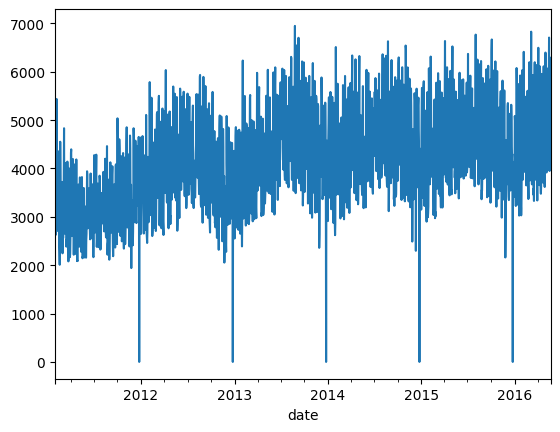

In [201]:
store_CA1['CA_1'].plot(subplots = True)

In [290]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(store_CA1)

In [292]:
features = data_scaled
target = data_scaled[:,0]

In [293]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size= 0.2, random_state=123, shuffle=False)

In [294]:
y_train

array([0.62420841, 0.59801382, 0.40529649, ..., 0.57498561, 0.50748417,
       0.51237766])

In [506]:
print(x_train.shape)
print(x_test.shape)

(1552, 5)
(389, 5)


In [507]:
win_length = 1
batch_size = 1
num_features = 5
train_gen = TimeseriesGenerator(x_train, y_train, length = win_length, sampling_rate=1, batch_size=batch_size)
test_gen = TimeseriesGenerator(x_test, y_test, length = win_length, sampling_rate=1, batch_size=batch_size)

In [509]:
model = Sequential()
model.add(LSTM(256, input_shape = (win_length, num_features), activation='relu', return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1))

In [510]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_62 (LSTM)                       │ (None, 1, 256)              │         268,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_63 (LSTM)                       │ (None, 1, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_64 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 514,881 (1.96 MB)

 Trainable params: 514,881 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [511]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3, mode = 'min')

In [512]:
model.compile(loss = 'mean_squared_error', optimizer='adam', metrics = ['mse'])

In [513]:
history = model.fit(x = train_gen, epochs = 20, validation_data = test_gen, shuffle = False, callbacks = [early_stopping], verbose=2)

Epoch 1/20
1551/1551 - 14s - 9ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 2/20
1551/1551 - 10s - 6ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 3/20
1551/1551 - 10s - 6ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 4/20
1551/1551 - 10s - 6ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 5/20
1551/1551 - 10s - 6ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 6/20
1551/1551 - 10s - 6ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 7/20
1551/1551 - 10s - 6ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 8/20
1551/1551 - 10s - 7ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 9/20
1551/1551 - 10s - 6ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 10/20
1551/1551 - 10s - 6ms/step - loss: 0.0114 - mse: 0.0

In [514]:
predictions = model.predict(test_gen)

388/388 ━━━━━━━━━━━━━━━━━━━━ 2:24 373ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [515]:
predictions.shape[0]

388

In [516]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis = 1)

In [517]:
rev_tran = scaler.inverse_transform(df_pred)

In [519]:
df_final = store_CA1[predictions.shape[0]*-1:]

In [520]:
df_final['sales_pred'] = rev_tran[:,0]

In [521]:
df_final

,CA_1,event_name_1,snap_CA,snap_TX,snap_WI,sales_pred
date,,,,,,
2015-05-01,5121,0,1,1,0,3851.734916
2015-05-02,5801,0,1,0,1,5008.756458
2015-05-03,6524,0,1,1,1,5243.675099
2015-05-04,4794,0,1,0,0,5173.402515
2015-05-05,4168,1,1,1,1,4737.110011
...,...,...,...,...,...,...
2016-05-18,3995,0,0,0,0,4287.703568
2016-05-19,4136,0,0,0,0,4337.394567
2016-05-20,4433,0,0,0,0,4482.450060


<Axes: xlabel='date'>

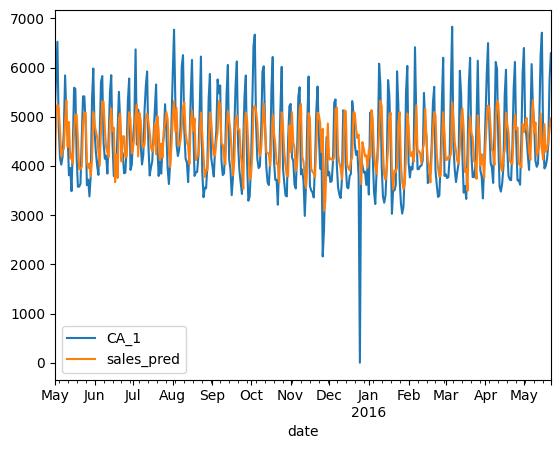

In [522]:
df_final[['CA_1','sales_pred']].plot()